<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_4_3_loss_regularizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from tqdm import tqdm
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fx = lambda x:torch.sin(x) + torch.cos(2*x) + x
X  = torch.linspace(-5, 5, 1000).resize(1000,1)
Y  = fx(X)

Xtrain = torch.linspace(-5, 5, 10).resize(10,1)
torch.manual_seed(1)
Ytrain = fx(Xtrain) + 1.2*torch.randn(size=Xtrain.size())

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
model = nn.Sequential(nn.Linear(1,100),
                      nn.ReLU(),
                      nn.Linear(100,100),
                      nn.ReLU(),
                      nn.Linear(100,100),
                      nn.ReLU(),
                      nn.Linear(100,1)
                    )
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  
def plot_loss(train_loss,test_loss):
  plt.semilogy(train_loss, label="Training Loss", color='red', linestyle="dashed", alpha=0.5)
  plt.semilogy(test_loss, label="Test Loss", color='black', alpha=0.5);
  plt.title("MSE Loss")
  plt.xlabel("Epoch")
  plt.legend()

def plot_regression():
  plt.plot(X, Y, color='black');
  plt.scatter(Xtrain, Ytrain, color="white", edgecolor="black")
  plt.plot(X, model(X).detach(), color='red', linestyle="dashed", linewidth=2);


In [ ]:
weights = [param for (name, param) in model.named_parameters() if "weight" in name]  

In [ ]:
def train_model(epochs, regularize=None, reg_rate=0.1):

  train_loss = torch.empty(epochs)
  test_loss  = torch.empty(epochs)
  weights    = [param for (name,param) in model.named_parameters() if
             "weight" in name]   
  for idx in tqdm(range(epochs)):
    optimizer.zero_grad()
    y_model  = model(Xtrain)
    MSE_loss = ((y_model-Ytrain)**2).mean()
    
    reg_loss = 0
    if regularize == "L2":
      for param in weights:
        #optimizer = torch.optim.SGD(model.parameters(), lr=0.01,weight_decay=reg_rate)
        #^this also regularizes the biases of each layer.
        reg_loss  += (param**2).sum()
    if regularize == "L1":
      for param in weights:
        reg_loss += 2*param.abs().sum()
    
    total_loss = MSE_loss + 1/2 * reg_rate * reg_loss
    total_loss.backward()
    optimizer.step()
    with torch.no_grad():
      train_loss[idx] = MSE_loss
      test_loss[idx]  = ((model(X) - Y)**2).mean()  
  return (train_loss, test_loss)

In [ ]:
(train_loss, test_loss) = train_model(2000)

100%|██████████| 2000/2000 [00:10<00:00, 188.51it/s]


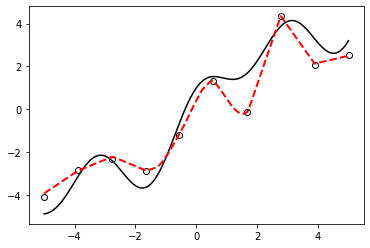

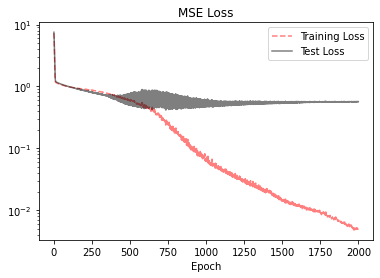

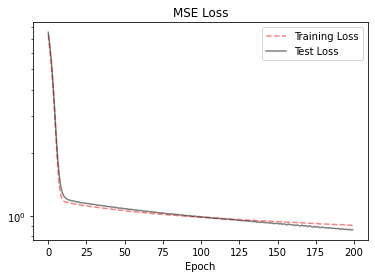

In [ ]:
plot_regression()
plt.show()
plot_loss(train_loss, test_loss)
plt.show()
plot_loss(train_loss[:200], test_loss[:200])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

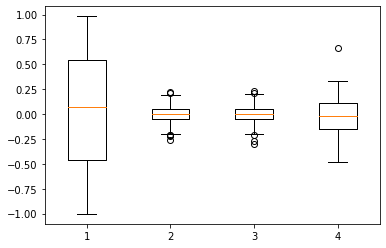

In [ ]:
weights = [param.detach() for (name,param) in model.named_parameters() if "weight" in name]
plt.boxplot(weights);

#L2 Regularization

In [ ]:
for layer in model:
  if hasattr(layer, "reset_parameters"):
    layer.reset_parameters()
(train_loss, test_loss) = train_model(epochs=2000, regularize="L2", reg_rate=0.3)

100%|██████████| 2000/2000 [00:05<00:00, 392.56it/s]


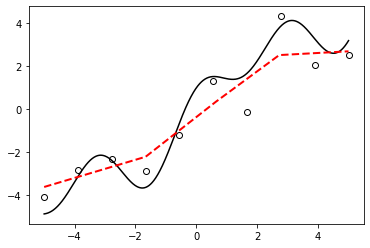

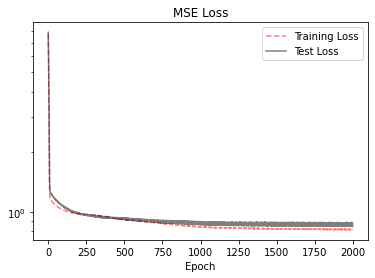

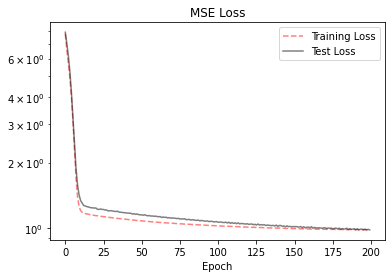

In [ ]:
plot_regression()
plt.show()
plot_loss(train_loss, test_loss)
plt.show()
plot_loss(train_loss[:200], test_loss[:200])

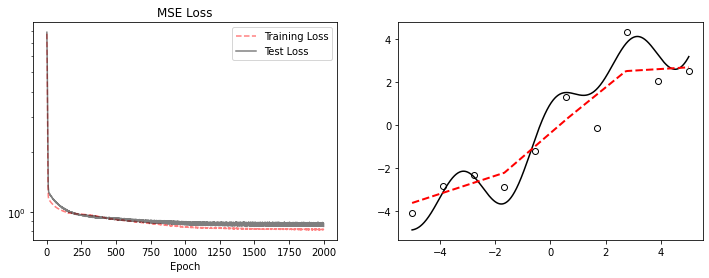

In [ ]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plot_loss(train_loss, test_loss)
plt.subplot(1,2,2)
plot_regression()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

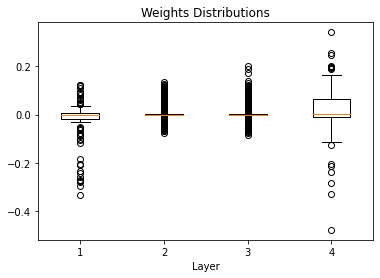

In [ ]:
weights = [param.detach() for (name, param) in model.named_parameters() if "weight" in name]
plt.boxplot(weights);
plt.xlabel("Layer");
plt.title("Weights Distributions");

In [ ]:
[((x.abs() > 10**-2).sum()) / x.numel() for x in weights]

[tensor(0.4900), tensor(0.1133), tensor(0.1126), tensor(0.6300)]

#L1 Regularization

In [ ]:
for layer in model:
  if hasattr(layer, "reset_parameters"):
    layer.reset_parameters()
(train_loss, test_loss) = train_model(epochs=2000, regularize="L1", reg_rate=0.1)

100%|██████████| 2000/2000 [00:05<00:00, 384.73it/s]


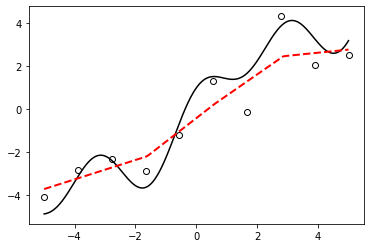

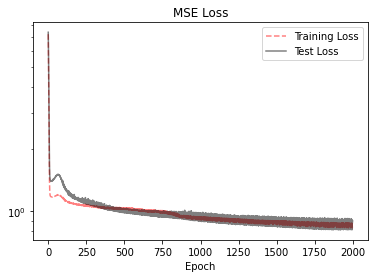

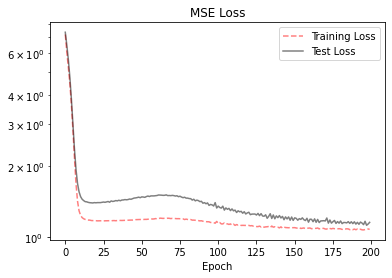

In [ ]:
plot_regression()
plt.show()
plot_loss(train_loss, test_loss)
plt.show()
plot_loss(train_loss[:200], test_loss[:200])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

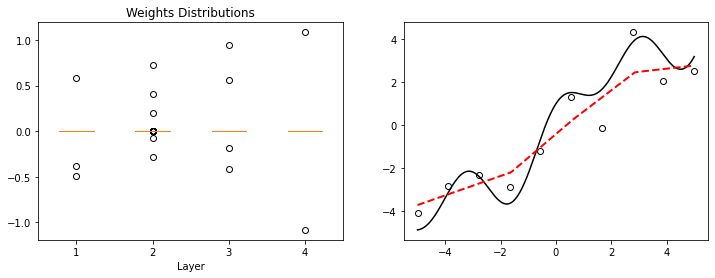

In [ ]:
weights = [param.detach() for (name, param) in model.named_parameters() if "weight" in name]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.boxplot(weights);
plt.xlabel("Layer");
plt.title("Weights Distributions");
plt.subplot(1,2,2)
plot_regression()

In [ ]:
[((x.abs() > 10**-3).sum()) / x.numel() for x in weights]

[tensor(0.0300), tensor(0.0047), tensor(0.0009), tensor(0.0200)]

#Over Regularization

In [ ]:
for layer in model:
  if hasattr(layer, "reset_parameters"):
    layer.reset_parameters()
(train_loss, test_loss) = train_model(epochs=2000, regularize="L2", reg_rate=10)

100%|██████████| 2000/2000 [01:46<00:00, 18.75it/s]


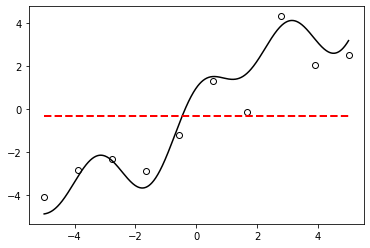

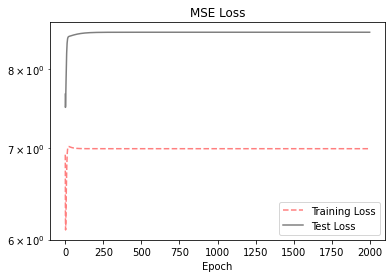

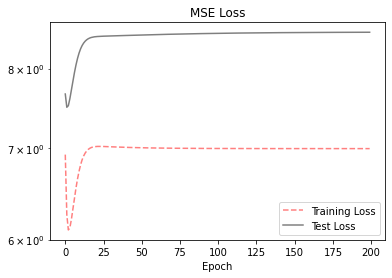

In [ ]:
plot_regression()
plt.show()
plot_loss(train_loss, test_loss)
plt.show()
plot_loss(train_loss[:200], test_loss[:200])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

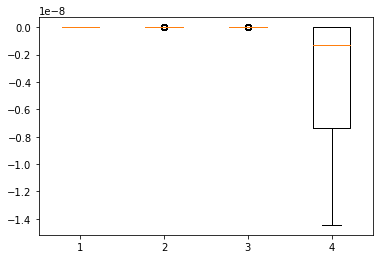

In [ ]:
weights = [param.detach() for (name, param) in model.named_parameters() if "weight" in name]
plt.boxplot(weights);